# Semantic Similarity Metric Comparison

This notebook loads the section-level similarity scores calculated by different methods (TF-IDF, SBERT variants, LLM) for two different datasets ('SIMILAR' and 'different') and visualizes the results for comparison.

## 1. Setup and Configuration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import numpy as np # For handling potential NaN values

# --- Configuration ---

# Adjust these paths if your files are named differently or located elsewhere
RESULTS_DIR = ""
SIMILAR_SCORES_FILE = os.path.join(RESULTS_DIR, "similar_section_scores.json")
DIFFERENT_SCORES_FILE = os.path.join(RESULTS_DIR, "different_section_scores.json")

# Define labels for the datasets
SIMILAR_DATASET_LABEL = "Similar"
DIFFERENT_DATASET_LABEL = "Different"

# Set plot style (optional)
sns.set_theme(style="whitegrid")

## 2. Data Loading Function

We define a function to load the JSON data and transform it into a tidy Pandas DataFrame suitable for plotting. Each row will represent a score for a specific method on a specific section within a specific dataset.

In [2]:
def load_scores_to_dataframe(filepath: str, dataset_label: str) -> pd.DataFrame | None:
    """
    Loads section scores from a JSON file and converts them into a Pandas DataFrame.

    Args:
        filepath: Path to the JSON file containing section scores.
        dataset_label: A string label to identify this dataset (e.g., 'Original').

    Returns:
        A Pandas DataFrame with columns ['section', 'method', 'score', 'dataset'],
        or None if the file cannot be loaded or parsed.
    """
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return None

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {filepath}")
        return None
    except Exception as e:
        print(f"Error loading file {filepath}: {e}")
        return None

    records = []
    for section_key, section_data in data.items():
        # Check if scores exist and are a dictionary
        if isinstance(section_data, dict) and "scores" in section_data and isinstance(section_data["scores"], dict):
            for method, score in section_data["scores"].items():
                # Convert None (from JSON null) or handle potential strings back to NaN if needed
                if score is None:
                    score_value = np.nan
                else:
                    try:
                        # Ensure score is float, handle potential non-numeric values gracefully
                        score_value = float(score)
                    except (ValueError, TypeError):
                        score_value = np.nan
                        print(f"Warning: Could not convert score '{score}' to float for {section_key} - {method}. Setting to NaN.")

                records.append({
                    "section": section_key,
                    "method": method,
                    "score": score_value,
                    "dataset": dataset_label
                })
        else:
             print(f"Warning: Skipping section '{section_key}' in {filepath} due to unexpected format or missing 'scores'. Data: {section_data}")


    if not records:
        print(f"Warning: No valid score records found in {filepath}")
        return pd.DataFrame(columns=["section", "method", "score", "dataset"]) # Return empty DF

    return pd.DataFrame(records)

## 3. Load and Combine Data

In [3]:
df_similar = load_scores_to_dataframe(SIMILAR_SCORES_FILE, SIMILAR_DATASET_LABEL)
df_different = load_scores_to_dataframe(DIFFERENT_SCORES_FILE, DIFFERENT_DATASET_LABEL)

# Combine the dataframes if both were loaded successfully
if df_similar is not None and df_different is not None:
    df_combined = pd.concat([df_similar, df_different], ignore_index=True)
    print(f"Successfully loaded and combined data.")
    print(f"Total records: {len(df_combined)}")
elif df_similar is not None:
    df_combined = df_similar
    print("Warning: Only SIMILAR dataset loaded.")
elif df_different is not None:
    df_combined = df_different
    print("Warning: Only different dataset loaded.")
else:
    df_combined = None
    print("Error: Failed to load data from both files. Cannot proceed with combined analysis.")

# Display basic info and check for missing values if data loaded
if df_combined is not None:
    print("\nCombined DataFrame Info:")
    df_combined.info()

    print("\nMissing values per column:")
    print(df_combined.isnull().sum())

    # Filter out rows where score is NaN for plotting distributions
    df_plot = df_combined.dropna(subset=['score'])
    print(f"\nRecords remaining after dropping NaN scores: {len(df_plot)}")

    print("\nValue counts for methods:")
    print(df_plot['method'].value_counts())

    print("\nValue counts for datasets:")
    print(df_plot['dataset'].value_counts())

    print("\nFirst 5 rows of combined data:")
    print(df_plot.head())

Successfully loaded and combined data.
Total records: 186

Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   section  186 non-null    object 
 1   method   186 non-null    object 
 2   score    186 non-null    float64
 3   dataset  186 non-null    object 
dtypes: float64(1), object(3)
memory usage: 5.9+ KB

Missing values per column:
section    0
method     0
score      0
dataset    0
dtype: int64

Records remaining after dropping NaN scores: 186

Value counts for methods:
method
tfidf_cosine                        31
sbert_cosine_mpnet_base_v2          31
sbert_cosine_nomic_v2_moe           31
sbert_cosine_nomic_v1_5_bert_tok    31
llm_judge_similarity                31
gemini_cosine                       31
Name: count, dtype: int64

Value counts for datasets:
dataset
Similar      126
Different     60
Name: count, dtype: int64

## 4. Visualization

We will use box plots and violin plots to compare the distribution of similarity scores for each method across the two datasets.

In [4]:
# Define the order of methods for plotting if needed (adjust based on your method keys)
method_order = sorted(df_plot['method'].unique()) if df_combined is not None else []
print(f"Plotting order for methods: {method_order}")

Plotting order for methods: ['gemini_cosine', 'llm_judge_similarity', 'sbert_cosine_mpnet_base_v2', 'sbert_cosine_nomic_v1_5_bert_tok', 'sbert_cosine_nomic_v2_moe', 'tfidf_cosine']


### 4.1 Box Plot Comparison

Box plots show the median (orange line), interquartile range (IQR, the box), whiskers (typically 1.5 * IQR), and outliers (individual points).

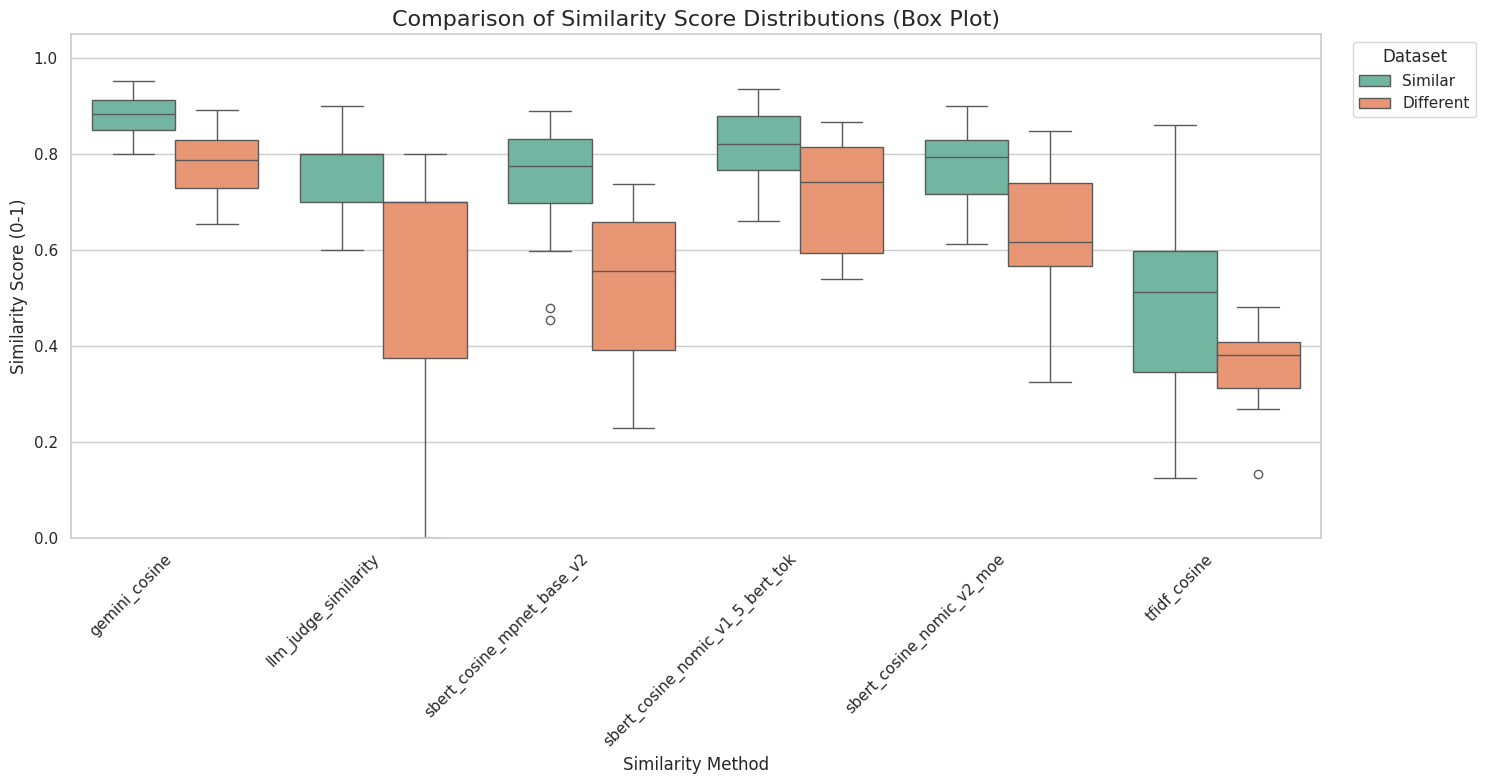

In [5]:
if df_combined is not None and not df_plot.empty:
    plt.figure(figsize=(15, 8)) # Adjust figure size as needed

    sns.boxplot(
        data=df_plot,
        x="method",
        y="score",
        hue="dataset", # Separate boxes for each dataset
        order=method_order, # Control the order of methods on x-axis
        palette="Set2" # Color palette
    )

    plt.title('Comparison of Similarity Score Distributions (Box Plot)', fontsize=16)
    plt.xlabel('Similarity Method', fontsize=12)
    plt.ylabel('Similarity Score (0-1)', fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
    plt.ylim(0, 1.05) # Set y-axis limits
    plt.legend(title='Dataset', bbox_to_anchor=(1.02, 1), loc='upper left') # Place legend outside plot
    plt.tight_layout() # Adjust layout to prevent labels overlapping plot area
    plt.show()
else:
    print("Cannot generate Box Plot: No valid data loaded or available after filtering NaNs.")

### 4.2 Violin Plot Comparison

Violin plots combine a box plot with a kernel density estimate, showing the probability density of the data at different values. They can be more informative about the shape of the distribution than plain box plots.

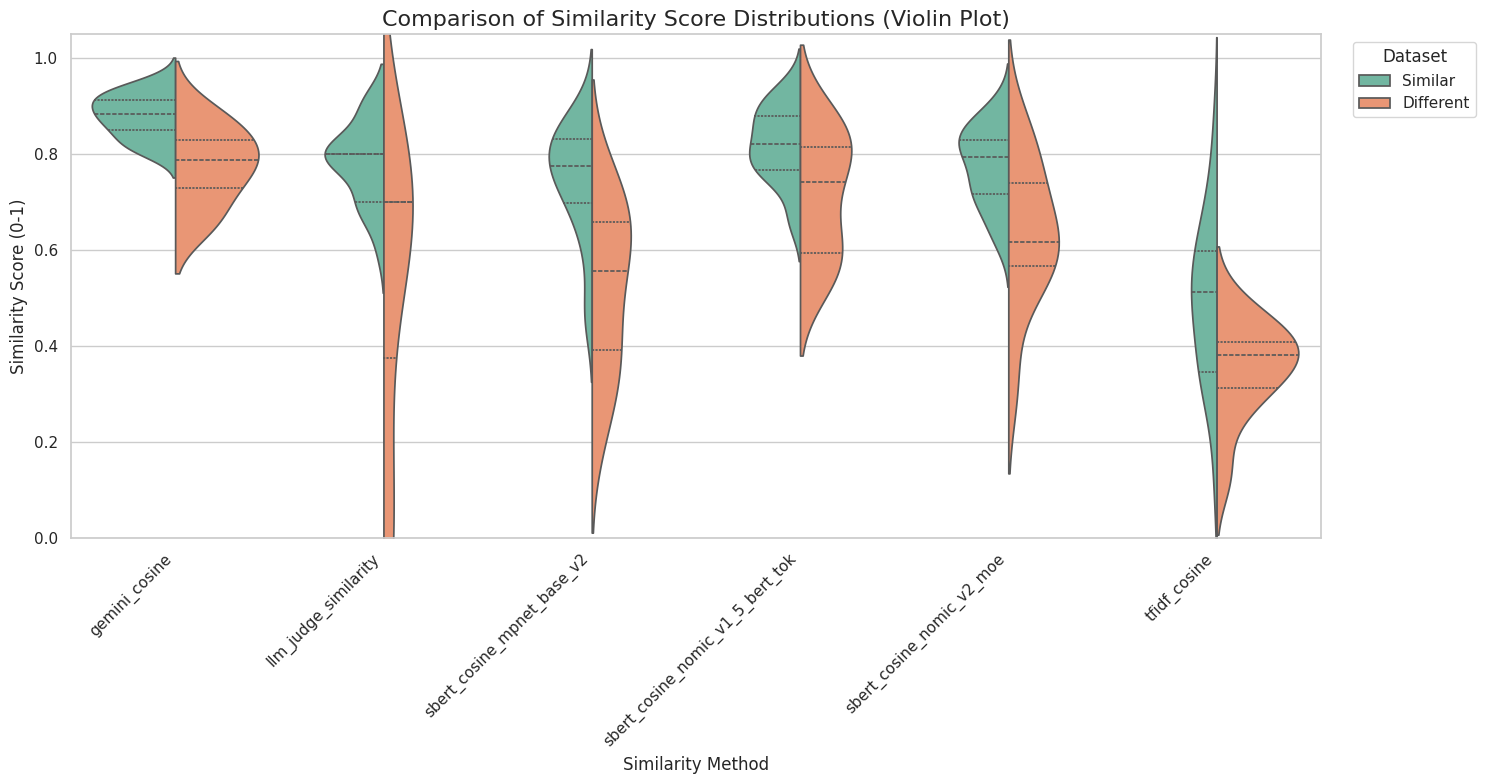

In [6]:
if df_combined is not None and not df_plot.empty:
    plt.figure(figsize=(15, 8))

    sns.violinplot(
        data=df_plot,
        x="method",
        y="score",
        hue="dataset",
        order=method_order,
        palette="Set2",
        split=True, # Combine violins for the two datasets side-by-side for easier comparison
        inner="quart" # Show quartile lines inside the violins (like a mini box plot)
        # Use inner="box" to show a mini-box plot, or inner="stick" for individual points, or None
    )

    plt.title('Comparison of Similarity Score Distributions (Violin Plot)', fontsize=16)
    plt.xlabel('Similarity Method', fontsize=12)
    plt.ylabel('Similarity Score (0-1)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.05)
    plt.legend(title='Dataset', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate Violin Plot: No valid data loaded or available after filtering NaNs.")

### 4.3 Separate Plots per Dataset

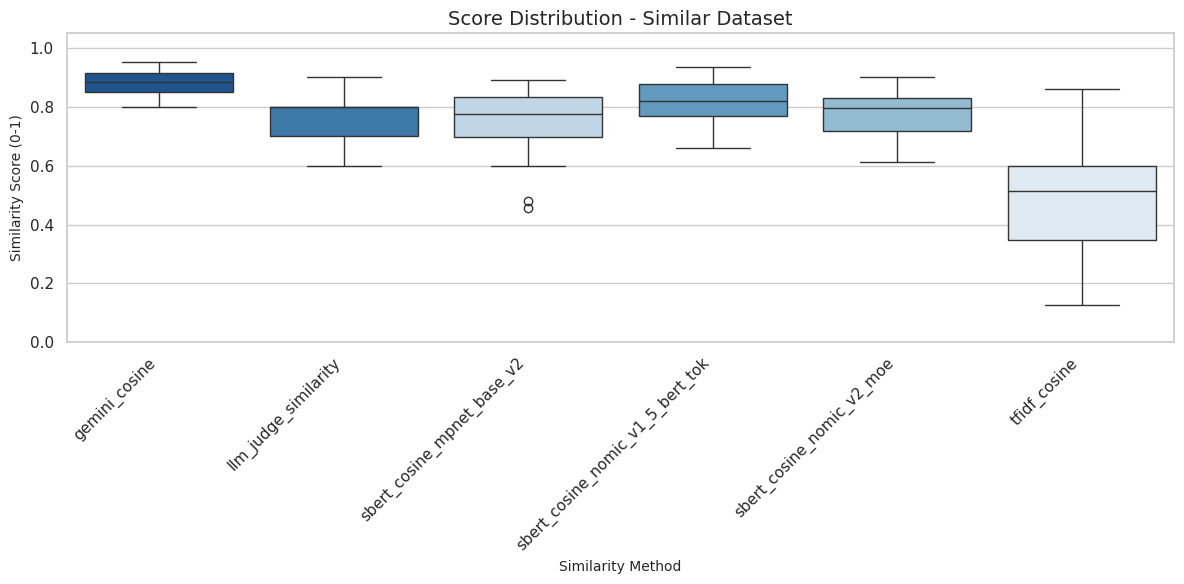

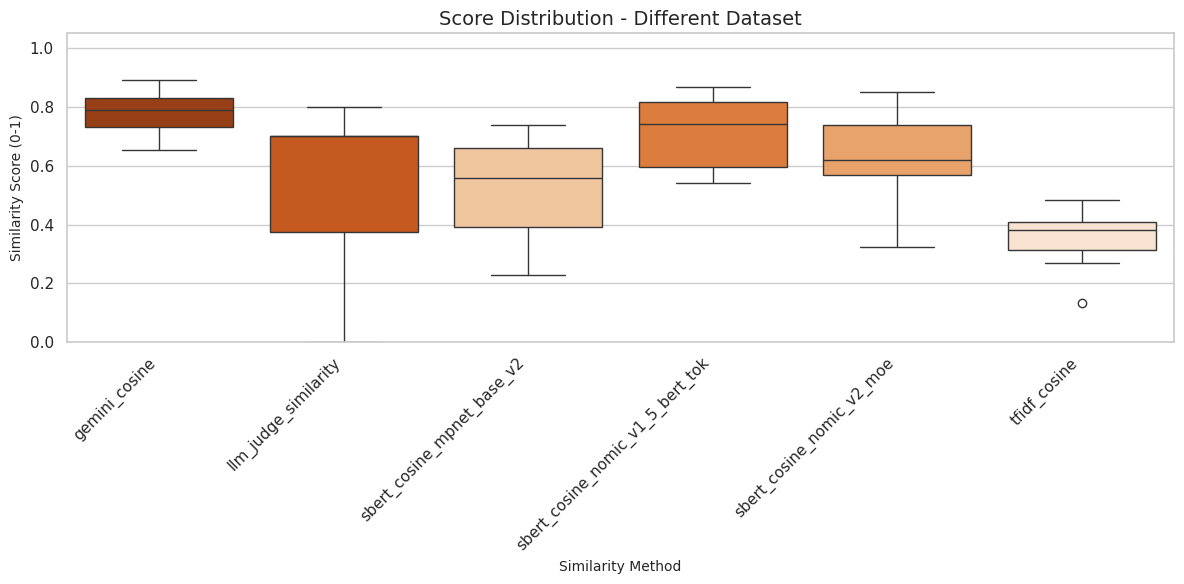

In [7]:
if df_combined is not None and not df_plot.empty:
    # Plot for Original Dataset
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_plot[df_plot['dataset'] == SIMILAR_DATASET_LABEL], x='method', y='score', order=method_order, hue='method', palette="Blues", legend=False)
    plt.title(f'Score Distribution - {SIMILAR_DATASET_LABEL} Dataset', fontsize=14)
    plt.xlabel('Similarity Method', fontsize=10)
    plt.ylabel('Similarity Score (0-1)', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

    # Plot for Different Dataset
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_plot[df_plot['dataset'] == DIFFERENT_DATASET_LABEL], x='method', y='score', order=method_order, hue='method', palette="Oranges", legend=False)
    plt.title(f'Score Distribution - {DIFFERENT_DATASET_LABEL} Dataset', fontsize=14)
    plt.xlabel('Similarity Method', fontsize=10)
    plt.ylabel('Similarity Score (0-1)', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

## 5. Summary Statistics

Displaying summary statistics grouped by method and dataset can complement the plots.

In [8]:
if df_combined is not None and not df_plot.empty:
    print("\nSummary Statistics (Mean, Std Dev, Median) per Method and Dataset:")
    summary_stats = df_plot.groupby(['dataset', 'method'])['score'].agg(['mean', 'std', 'median', 'count'])
    print(summary_stats)
else:
    print("Cannot generate summary statistics: No valid data.")


Summary Statistics (Mean, Std Dev, Median) per Method and Dataset:
                                                mean       std    median  \
dataset   method                                                           
Different gemini_cosine                     0.775828  0.080792  0.788011   
          llm_judge_similarity              0.520000  0.304777  0.700000   
          sbert_cosine_mpnet_base_v2        0.520072  0.172856  0.557520   
          sbert_cosine_nomic_v1_5_bert_tok  0.715268  0.127116  0.743073   
          sbert_cosine_nomic_v2_moe         0.633534  0.150378  0.618167   
          tfidf_cosine                      0.353822  0.099492  0.381818   
Similar   gemini_cosine                     0.879926  0.045448  0.884638   
          llm_judge_similarity              0.784127  0.081390  0.800000   
          sbert_cosine_mpnet_base_v2        0.744029  0.118427  0.774805   
          sbert_cosine_nomic_v1_5_bert_tok  0.819793  0.077445  0.821391   
          sbert_cosi